In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load and Clean Data
df = pd.read_csv('../data/us_disaster_declarations.csv')

# Filter for mainland states
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df = df[df['state'].isin(mainland_states)]

# Drop irrelevant columns
columns_to_drop = [
    "fema_declaration_string", "fips", "place_code", "hash", "id", "last_refresh", 
    "last_ia_filing_date", "fy_declared", "ih_program_declared", "ia_program_declared", 
    "declaration_type", "pa_program_declared", "hm_program_declared", 
    "disaster_closeout_date", "declaration_request_number"
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Convert dates and sort
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date']).dt.tz_localize(None)
df.sort_values('incident_begin_date', inplace=True)

# Aggregate monthly disaster counts
monthly_disasters = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size()
monthly_disasters = monthly_disasters.to_frame(name='disaster_count')

# Log transformation to manage outliers
monthly_disasters['disaster_count'] = np.log1p(monthly_disasters['disaster_count'])

# Add cyclical features for seasonality
monthly_disasters['month_sin'] = np.sin(2 * np.pi * (monthly_disasters.index.month / 12))
monthly_disasters['month_cos'] = np.cos(2 * np.pi * (monthly_disasters.index.month / 12))

# Normalize Data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(monthly_disasters)
scaled_df = pd.DataFrame(scaled_features, columns=monthly_disasters.columns, index=monthly_disasters.index)

# Create Sequences
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length].values
        label = data.iloc[i + seq_length, 0]  # Predict disaster count
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 36  # Increased sequence length to capture longer dependencies
X, y = create_sequences(scaled_df, seq_length)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Build the Bidirectional LSTM Model
model = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=False, input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.4),  # Increased dropout for regularization
    Dense(1)  # Output disaster count
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')  # Lower learning rate for fine-tuning

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the Model
y_pred = model.predict(X_test)

# Rescale Predictions
y_pred_rescaled = np.expm1(y_pred)  # Reverse log transformation
y_test_rescaled = np.expm1(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Disaster Count', marker='o')
plt.plot(y_pred_rescaled, label='Predicted Disaster Count', linestyle='--')
plt.title('Actual vs Predicted Disaster Counts')
plt.xlabel('Time Steps')
plt.ylabel('Disaster Count')
plt.legend()
plt.grid()
plt.show()


TypeError: string indices must be integers

/tmp/ipykernel_961/1172418817.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size().reset_index(name='disaster_count')


Epoch 1/50


/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5097 - loss: 22.9818 - val_accuracy: 0.6149 - val_loss: 38.1551
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6223 - loss: 16.9156 - val_accuracy: 0.7267 - val_loss: 22.9133
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6708 - loss: 11.6003 - val_accuracy: 0.6832 - val_loss: 24.9630
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7167 - loss: 7.8723 - val_accuracy: 0.7516 - val_loss: 12.7934
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6741 - loss: 10.2575 - val_accuracy: 0.7640 - val_loss: 7.2994
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6962 - loss: 7.8152 - val_accuracy: 0.9068 - val_loss: 4.7692
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7436 - loss: 6.2913 - val_accuracy: 0.8634 - val_loss: 20.6714
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7631 - loss: 8.6683 - val_accuracy: 0.9255 - val

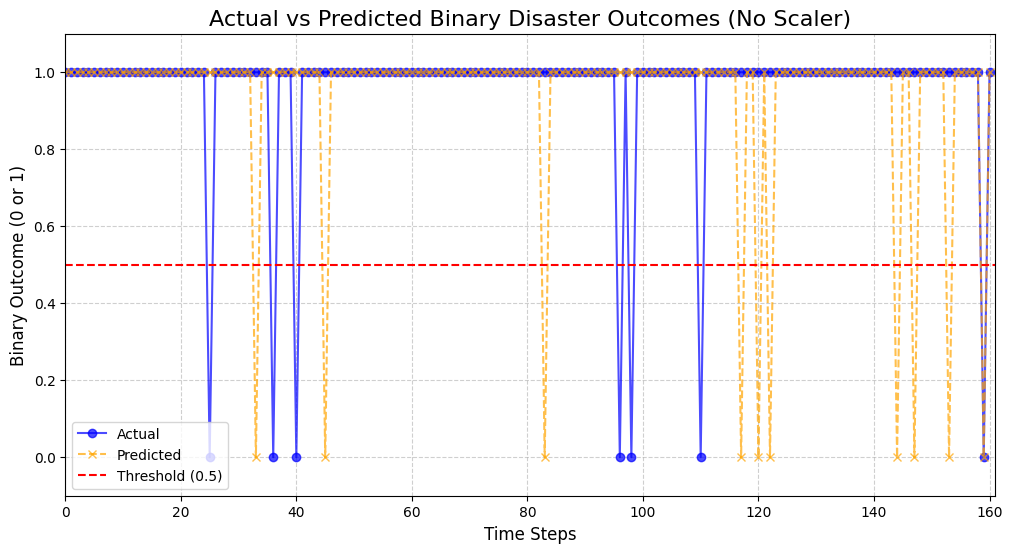

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('../data/us_disaster_declarations.csv')

# Preprocess dataset
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date'])
df = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size().reset_index(name='disaster_count')

# Remove MinMaxScaler
# We'll directly use raw `disaster_count` values for training/testing
# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length]['disaster_count'].values.reshape(-1, 1)
        label = 1 if data.iloc[i + seq_length]['disaster_count'] > 0 else 0
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Set sequence length and create sequences
seq_length = 36
X, y = create_sequences(df, seq_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Build the LSTM model
fine_tuned_lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    LSTM(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
fine_tuned_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = fine_tuned_lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Make predictions
y_pred_prob = fine_tuned_lstm_model.predict(X_test)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)

print(f"Accuracy (No Scaler): {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Improved Plot: Focus on the region with changes
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test, label='Actual', marker='o', linestyle='-', color='blue', alpha=0.7)

# Plot predicted values
plt.plot(y_pred_binary, label='Predicted', linestyle='--', marker='x', color='orange', alpha=0.7)

# Add a horizontal line at 0.5 for the classification threshold
plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)')

# Focus on the region with non-zero or significant predictions
non_zero_indices = np.where(y_test > 0)[0]
if len(non_zero_indices) > 0:
    min_idx = max(0, non_zero_indices.min() - 5)  # Add some padding for readability
    max_idx = min(len(y_test), non_zero_indices.max() + 5)
    plt.xlim(min_idx, max_idx)

# Enhancements
plt.title('Actual vs Predicted Binary Disaster Outcomes (No Scaler)', fontsize=16)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Binary Outcome (0 or 1)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Optional: Adjust y-axis limits to focus on the binary range
plt.ylim(-0.1, 1.1)

# Show the plot
plt.show()


Epoch 1/50


/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4513 - loss: 15.4376 - val_accuracy: 0.8944 - val_loss: 4.0117
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5171 - loss: 5.0999 - val_accuracy: 0.8820 - val_loss: 3.4269
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5910 - loss: 3.9691 - val_accuracy: 0.8820 - val_loss: 9.6076
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6156 - loss: 9.4088 - val_accuracy: 0.9193 - val_loss: 17.9045
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6613 - loss: 4.9793 - val_accuracy: 0.8385 - val_loss: 21.3463
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6453 - loss: 3.0590 - val_accuracy: 0.8820 - val_loss: 3.6720
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6276 - loss: 1.5305 - val_accuracy: 0.9006 - val_loss: 1.9407
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6325 - loss: 1.1853 - val_accuracy: 0.9068 - val_loss:

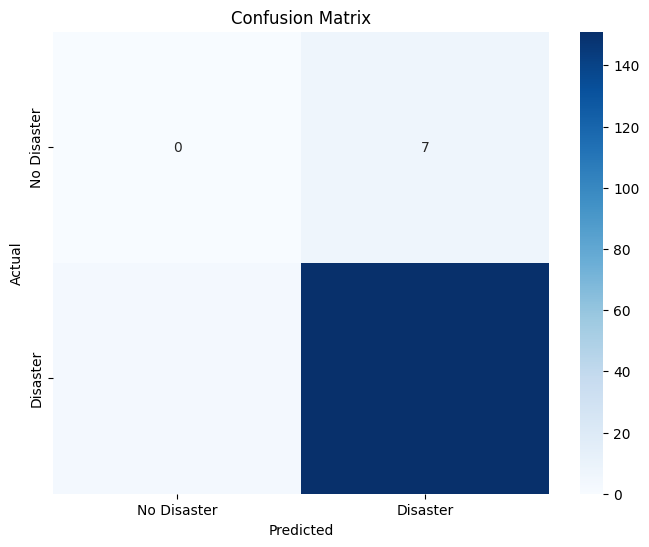

In [4]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
import seaborn as sns

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape X_train back to LSTM input shape
X_train_resampled = X_train_resampled.reshape(-1, seq_length, 1)

# Build the updated LSTM model
balanced_lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])),
    Dropout(0.4),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification with sigmoid
])

# Compile the model with weighted loss
balanced_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = balanced_lstm_model.fit(
    X_train_resampled, y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate the model
y_pred_balanced = (balanced_lstm_model.predict(X_test) > 0.5).astype(int)
print("Classification Report (Balanced Model):")
print(classification_report(y_test, y_pred_balanced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_balanced):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_balanced)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disaster", "Disaster"], yticklabels=["No Disaster", "Disaster"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/50


/tmp/ipykernel_961/1328093639.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - disaster_count_output_loss: 0.1126 - loss: 0.7872 - no_disaster_output_accuracy: 0.5843 - no_disaster_output_loss: 0.6742 - val_disaster_count_output_loss: 0.0311 - val_loss: 0.4417 - val_no_disaster_output_accuracy: 0.9441 - val_no_disaster_output_loss: 0.4050
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - disaster_count_output_loss: 0.0558 - loss: 0.5460 - no_disaster_output_accuracy: 0.8159 - no_disaster_output_loss: 0.4899 - val_disaster_count_output_loss: 0.0318 - val_loss: 0.2805 - val_no_disaster_output_accuracy: 0.9441 - val_no_disaster_output_loss: 0.2372
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - disaster_count_output_loss: 0.0485 - loss: 0.4611 - no_disaster_output_accuracy: 0.8384 - no_disaster_output_loss: 0.4130 - val_disaster_count_output_loss: 0.0319 - val_loss: 0.2838 - val_no_disaster_output_accuracy: 0.9441 - val_no_disaster_output_loss: 0.2403
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - disaster_coun

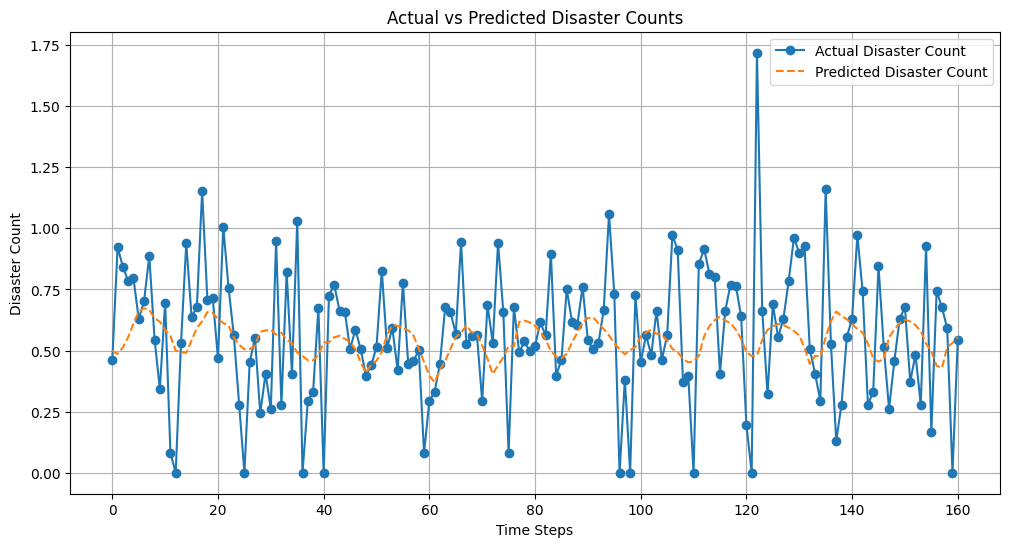

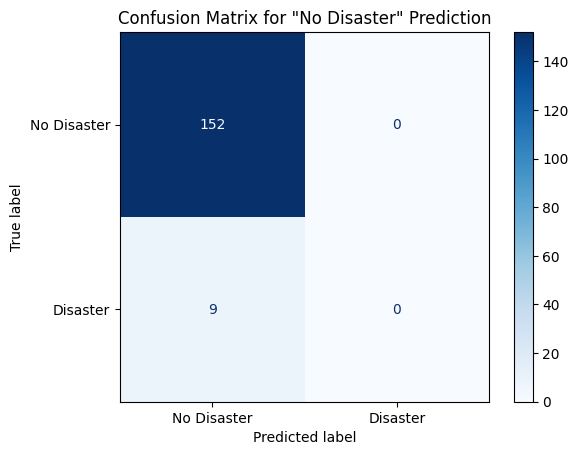

In [5]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load and Clean Data
df = pd.read_csv('../data/us_disaster_declarations.csv')

# Filter for mainland states
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df = df[df['state'].isin(mainland_states)]

# Drop irrelevant columns
columns_to_drop = [
    "fema_declaration_string", "fips", "place_code", "hash", "id", "last_refresh", 
    "last_ia_filing_date", "fy_declared", "ih_program_declared", "ia_program_declared", 
    "declaration_type", "pa_program_declared", "hm_program_declared", 
    "disaster_closeout_date", "declaration_request_number"
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Convert dates and sort
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date']).dt.tz_localize(None)
df.sort_values('incident_begin_date', inplace=True)

# Aggregate monthly disaster counts
monthly_disasters = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size()
monthly_disasters = monthly_disasters.to_frame(name='disaster_count')

# Log transformation to manage outliers
monthly_disasters['disaster_count'] = np.log1p(monthly_disasters['disaster_count'])

# Add "No Disaster" Feature
monthly_disasters['no_disaster'] = (monthly_disasters['disaster_count'] == 0).astype(int)

# Add cyclical features for seasonality
monthly_disasters['month_sin'] = np.sin(2 * np.pi * (monthly_disasters.index.month / 12))
monthly_disasters['month_cos'] = np.cos(2 * np.pi * (monthly_disasters.index.month / 12))

# Normalize Data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(monthly_disasters)
scaled_df = pd.DataFrame(scaled_features, columns=monthly_disasters.columns, index=monthly_disasters.index)

# Create Sequences
def create_sequences(data, seq_length):
    sequences, disaster_labels, binary_labels = [], [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length].values
        disaster_label = data.iloc[i + seq_length, 0]  # Predict disaster count
        binary_label = data.iloc[i + seq_length, 1]   # Predict "No Disaster" binary feature
        sequences.append(seq)
        disaster_labels.append(disaster_label)
        binary_labels.append(binary_label)
    return np.array(sequences), np.array(disaster_labels), np.array(binary_labels)

seq_length = 36  # Increased sequence length to capture longer dependencies
X, y_disaster, y_binary = create_sequences(scaled_df, seq_length)

# Train-Test Split
X_train, X_test, y_disaster_train, y_disaster_test, y_binary_train, y_binary_test = train_test_split(
    X, y_disaster, y_binary, test_size=0.2, random_state=42, shuffle=False
)

# Build the Multi-Task LSTM Model
input_layer = Input(shape=(seq_length, X_train.shape[2]))
lstm_layer = Bidirectional(LSTM(64, activation='relu', return_sequences=False))(input_layer)
dropout_layer = Dropout(0.4)(lstm_layer)

# Output 1: Disaster Count (Regression)
regression_output = Dense(1, name='disaster_count_output')(dropout_layer)

# Output 2: No Disaster (Binary Classification)
binary_output = Dense(1, activation='sigmoid', name='no_disaster_output')(dropout_layer)

# Compile the Model
model = Model(inputs=input_layer, outputs=[regression_output, binary_output])
model.compile(
    optimizer=Adam(learning_rate=0.0005), 
    loss={'disaster_count_output': 'mse', 'no_disaster_output': 'binary_crossentropy'},
    metrics={'no_disaster_output': 'accuracy'}
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, 
    {'disaster_count_output': y_disaster_train, 'no_disaster_output': y_binary_train},
    validation_data=(X_test, {'disaster_count_output': y_disaster_test, 'no_disaster_output': y_binary_test}),
    epochs=50, 
    batch_size=16, 
    callbacks=[early_stopping]
)

# Evaluate the Model
evaluation = model.evaluate(X_test, {'disaster_count_output': y_disaster_test, 'no_disaster_output': y_binary_test})
print("Evaluation Results:", evaluation)

# Predict
y_disaster_pred, y_binary_pred = model.predict(X_test)

# Rescale Predictions
y_disaster_pred_rescaled = np.expm1(y_disaster_pred)  # Reverse log transformation
y_disaster_test_rescaled = np.expm1(y_disaster_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_disaster_test_rescaled, y_disaster_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Binary Classification Metrics
y_binary_pred_class = (y_binary_pred > 0.5).astype(int)
binary_accuracy = accuracy_score(y_binary_test, y_binary_pred_class)
print(f"Binary Classification Accuracy: {binary_accuracy}")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_disaster_test_rescaled, label='Actual Disaster Count', marker='o')
plt.plot(y_disaster_pred_rescaled, label='Predicted Disaster Count', linestyle='--')
plt.title('Actual vs Predicted Disaster Counts')
plt.xlabel('Time Steps')
plt.ylabel('Disaster Count')
plt.legend()
plt.grid()
plt.show()

# Plot Confusion Matrix for Binary Classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_binary_test, y_binary_pred_class)
ConfusionMatrixDisplay(conf_matrix, display_labels=['No Disaster', 'Disaster']).plot(cmap='Blues')
plt.title('Confusion Matrix for "No Disaster" Prediction')
plt.show()


/tmp/ipykernel_961/656140480.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size()


Epoch 1/50


/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5504 - loss: 0.6876 - val_accuracy: 0.9441 - val_loss: 0.4924
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6498 - loss: 0.6180 - val_accuracy: 0.9441 - val_loss: 0.2851
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6811 - loss: 0.5981 - val_accuracy: 0.9441 - val_loss: 0.2926
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6871 - loss: 0.5929 - val_accuracy: 0.9441 - val_loss: 0.3135
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6960 - loss: 0.5939 - val_accuracy: 0.9441 - val_loss: 0.2733
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6787 - loss: 0.5998 - val_accuracy: 0.9441 - val_loss: 0.4844
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6600 - loss: 0.6214 - val_accuracy: 0.9441 - val_loss: 0.3933
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6647 - loss: 0.5978 - val_accuracy: 0.9441 - val_loss: 0.

/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


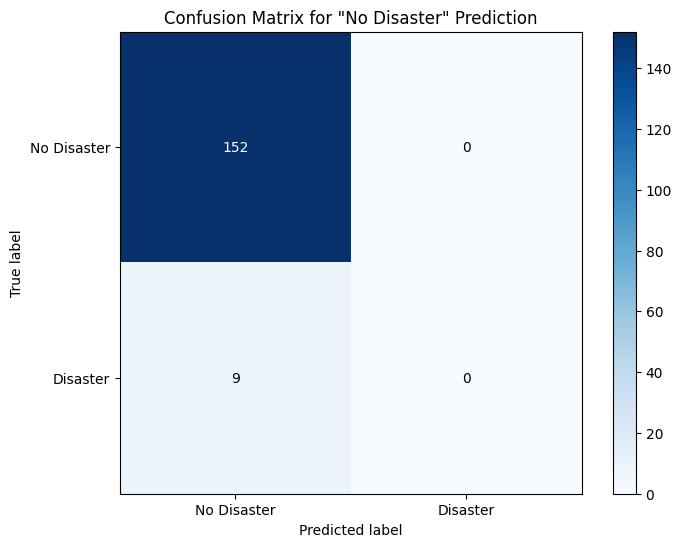

In [6]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Load and Clean Data
df = pd.read_csv('../data/us_disaster_declarations.csv')

# Filter for mainland states
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df = df[df['state'].isin(mainland_states)]

# Drop irrelevant columns
columns_to_drop = [
    "fema_declaration_string", "fips", "place_code", "hash", "id", "last_refresh", 
    "last_ia_filing_date", "fy_declared", "ih_program_declared", "ia_program_declared", 
    "declaration_type", "pa_program_declared", "hm_program_declared", 
    "disaster_closeout_date", "declaration_request_number"
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Convert dates and sort
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date']).dt.tz_localize(None)
df.sort_values('incident_begin_date', inplace=True)

# Aggregate monthly disaster counts
monthly_disasters = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size()
monthly_disasters = monthly_disasters.to_frame(name='disaster_count')

# Create Binary Classification Target
monthly_disasters['no_disaster'] = (monthly_disasters['disaster_count'] == 0).astype(int)

# Log transformation to manage outliers
monthly_disasters['disaster_count'] = np.log1p(monthly_disasters['disaster_count'])

# Add cyclical features for seasonality
monthly_disasters['month_sin'] = np.sin(2 * np.pi * (monthly_disasters.index.month / 12))
monthly_disasters['month_cos'] = np.cos(2 * np.pi * (monthly_disasters.index.month / 12))

# Normalize Data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(monthly_disasters.drop(columns=['no_disaster']))
scaled_df = pd.DataFrame(scaled_features, columns=monthly_disasters.columns[:-1], index=monthly_disasters.index)
scaled_df['no_disaster'] = monthly_disasters['no_disaster'].values

# Create Sequences
def create_sequences(data, seq_length):
    sequences, labels_disaster, labels_binary = [], [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length].drop(columns=['no_disaster']).values
        label_disaster = data.iloc[i + seq_length]['disaster_count']
        label_binary = data.iloc[i + seq_length]['no_disaster']
        sequences.append(seq)
        labels_disaster.append(label_disaster)
        labels_binary.append(label_binary)
    return np.array(sequences), np.array(labels_disaster), np.array(labels_binary)

seq_length = 36
X, y_disaster, y_binary = create_sequences(scaled_df, seq_length)

# Train-Test Split
X_train, X_test, y_disaster_train, y_disaster_test, y_binary_train, y_binary_test = train_test_split(
    X, y_disaster, y_binary, test_size=0.2, random_state=42, shuffle=False
)

# SMOTE for Balancing
y_binary_train_flat = y_binary_train.ravel()  # Ensure the label is 1D for SMOTE
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape for SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_binary_resampled = smote.fit_resample(X_train_reshaped, y_binary_train_flat)

# Reshape back after SMOTE
X_resampled = X_resampled.reshape(X_resampled.shape[0], seq_length, X_train.shape[2])

# Build the Bidirectional LSTM Model
model = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=False, input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_resampled, y_binary_resampled, 
    epochs=50, batch_size=16, 
    validation_data=(X_test, y_binary_test), 
    callbacks=[early_stopping]
)

# Evaluate the Model
y_pred_binary = (model.predict(X_test) > 0.5).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_binary_test, y_pred_binary))
print("Classification Report:\n", classification_report(y_binary_test, y_pred_binary))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_binary_test, y_pred_binary)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for "No Disaster" Prediction')
plt.colorbar()
ticks = ['No Disaster', 'Disaster']
plt.xticks(np.arange(2), ticks)
plt.yticks(np.arange(2), ticks)
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
plt.show()


Epoch 1/50


/tmp/ipykernel_961/2243168139.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size()
/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6487 - loss: 2.6134 - val_accuracy: 0.9441 - val_loss: 0.5072
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8024 - loss: 0.7891 - val_accuracy: 0.9441 - val_loss: 0.3154
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8266 - loss: 0.7063 - val_accuracy: 0.9441 - val_loss: 0.4044
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8026 - loss: 0.7445 - val_accuracy: 0.9441 - val_loss: 0.5094
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8248 - loss: 0.7028 - val_accuracy: 0.9441 - val_loss: 0.3486
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8095 - loss: 0.7396 - val_accuracy: 0.9441 - val_loss: 0.3619
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8005 - loss: 0.7663 - val_accuracy: 0.9441 - val_loss: 0.5081
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8260 - loss: 0.6880 - val_accuracy: 0.9441 - val_loss: 0.

/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.94      1.00      0.97       152

    accuracy                           0.94       161
   macro avg       0.47      0.50      0.49       161
weighted avg       0.89      0.94      0.92       161



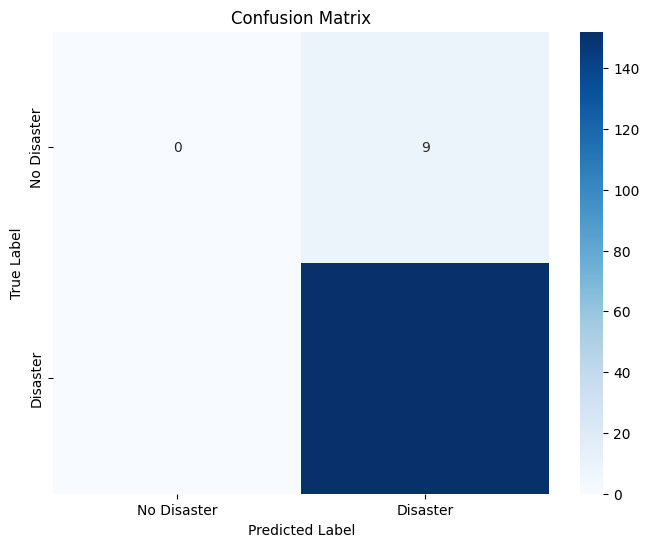

In [8]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Load and Clean Data
df = pd.read_csv('../data/us_disaster_declarations.csv')

# Filter for mainland states
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df = df[df['state'].isin(mainland_states)]

# Drop irrelevant columns
columns_to_drop = [
    "fema_declaration_string", "fips", "place_code", "hash", "id", "last_refresh", 
    "last_ia_filing_date", "fy_declared", "ih_program_declared", "ia_program_declared", 
    "declaration_type", "pa_program_declared", "hm_program_declared", 
    "disaster_closeout_date", "declaration_request_number"
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Convert dates and sort
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date']).dt.tz_localize(None)
df.sort_values('incident_begin_date', inplace=True)

# Aggregate monthly disaster counts
monthly_disasters = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size()
monthly_disasters = monthly_disasters.to_frame(name='disaster_count')

# Add additional features
monthly_disasters['month'] = monthly_disasters.index.month
monthly_disasters['year'] = monthly_disasters.index.year

# Add cyclical features for seasonality
monthly_disasters['month_sin'] = np.sin(2 * np.pi * (monthly_disasters['month'] / 12))
monthly_disasters['month_cos'] = np.cos(2 * np.pi * (monthly_disasters['month'] / 12))

# Add historical disaster averages for the same month
monthly_disasters['historical_avg_disasters'] = monthly_disasters.groupby('month')['disaster_count'].transform('mean')

# Add a mock temperature feature (replace with real data if available)
# Assuming higher temperatures in summer months
monthly_disasters['temperature'] = np.where(
    monthly_disasters['month'].isin([6, 7, 8]), 30, 15  # Mock data
)

# Normalize Data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(monthly_disasters)
scaled_df = pd.DataFrame(scaled_features, columns=monthly_disasters.columns, index=monthly_disasters.index)

# Create Sequences
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length].values
        label = 1 if data.iloc[i + seq_length, 0] > 0 else 0  # Binary classification
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 36  # Capture longer dependencies
X, y = create_sequences(scaled_df, seq_length)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Define a Custom Loss Function
def custom_loss(y_true, y_pred):
    weight_no_disaster = 5.0  # Heavier penalty for misclassifying "No Disaster"
    weight_disaster = 1.0

    loss = -(
        weight_no_disaster * y_true * tf.math.log(y_pred + tf.keras.backend.epsilon()) +
        weight_disaster * (1 - y_true) * tf.math.log(1 - y_pred + tf.keras.backend.epsilon())
    )
    return tf.reduce_mean(loss)

# Build the Bidirectional LSTM Model
model = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=False, input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss=custom_loss, metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the Model
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Disaster', 'Disaster'], yticklabels=['No Disaster', 'Disaster'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
